In [ ]:
!mamba install t-coffee mmseqs2 -y -q

In [1]:
from learnMSA.msa_hmm import Configuration, Align, Visualize, Emitter, Transitioner, Initializers, Training
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset

2023-08-18 15:49:58.735895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 15:49:58.815220: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-18 15:49:58.830169: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-18 15:49:59.074101: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvi

# Experimental demo: learnMSA + protein language model

This notebook demonstrates how to align a set of protein sequences with learnMSA supported by a large, pre-trained protein language model.

This configuration of learnMSA - although a prototype - is the most accurate variant of learnMSA currently available. It is also the most computationally expensive. It is recommended to run this notebook on a GPU.

In [2]:
# Your fasta file with unaligned sequences.

train_filename = "test/data/egf.fasta"

# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
# Replace with empty string if no reference is available.
ref_filename = "test/data/egf.ref"

# The number of independently trained models.
num_models = 10

HMM training supported by protein embeddings:

Training of 10 models on file egf.fasta
Configuration: 
{
num_models : 10
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=100

/home/beckerf/mambaforge/envs/learnMSAdev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-18 15:50:08.454156: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Fitting models of lengths [25 24 23 24 24 24 22 25 24 26] on 7774 sequences.
Batch size= 400 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 2 GPUs.
Found multiple GPUs, but using a language model is currently not supported in multi-GPU mode. Using single GPU.
Epoch 1/10


2023-08-18 15:53:35.098232: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x55d9db73dde0


22/22 - 18s - loss: 156.4754 - loglik: -1.2827e+02 - logprior: -2.8204e+01 - 18s/epoch - 818ms/step
Epoch 2/10
22/22 - 2s - loss: 100.7129 - loglik: -9.0224e+01 - logprior: -1.0488e+01 - 2s/epoch - 92ms/step
Epoch 3/10
22/22 - 2s - loss: 83.2148 - loglik: -7.6818e+01 - logprior: -6.3963e+00 - 2s/epoch - 87ms/step
Epoch 4/10
22/22 - 2s - loss: 77.6441 - loglik: -7.2948e+01 - logprior: -4.6960e+00 - 2s/epoch - 90ms/step
Epoch 5/10
22/22 - 2s - loss: 75.1261 - loglik: -7.1336e+01 - logprior: -3.7900e+00 - 2s/epoch - 84ms/step
Epoch 6/10
22/22 - 2s - loss: 73.7733 - loglik: -7.0510e+01 - logprior: -3.2631e+00 - 2s/epoch - 85ms/step
Epoch 7/10
22/22 - 2s - loss: 72.8898 - loglik: -6.9968e+01 - logprior: -2.9217e+00 - 2s/epoch - 90ms/step
Epoch 8/10
22/22 - 2s - loss: 72.1900 - loglik: -6.9486e+01 - logprior: -2.7041e+00 - 2s/epoch - 87ms/step
Epoch 9/10
22/22 - 2s - loss: 71.7085 - loglik: -6.9156e+01 - logprior: -2.5524e+00 - 2s/epoch - 89ms/step
Epoch 10/10
22/22 - 2s - loss: 71.2834 - lo

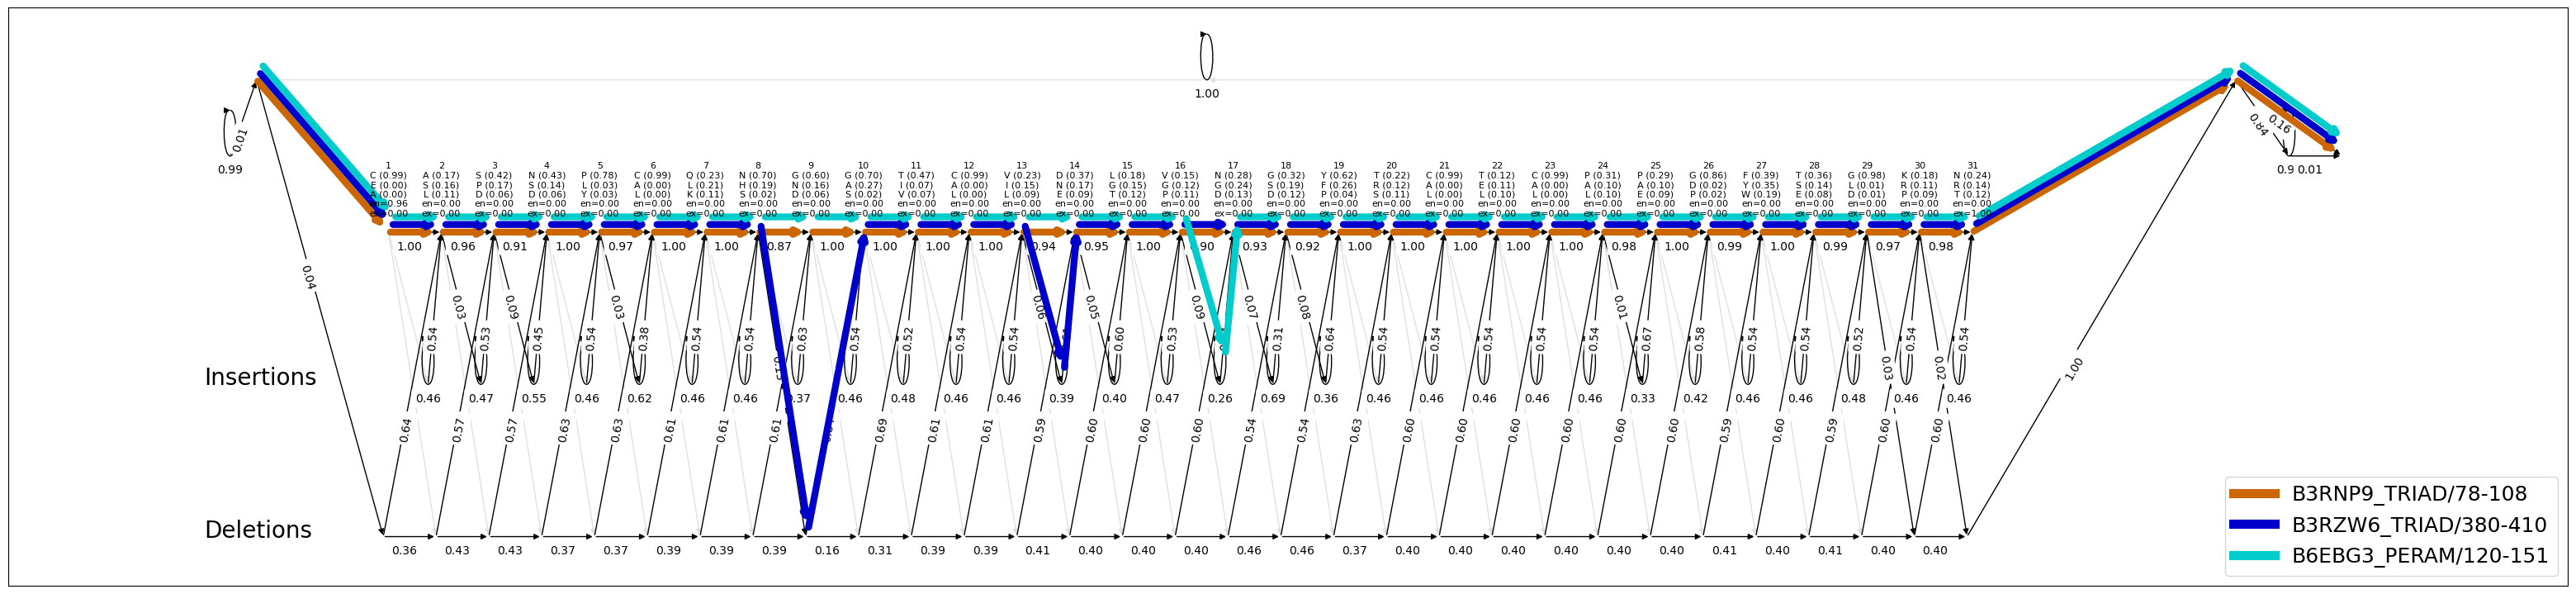

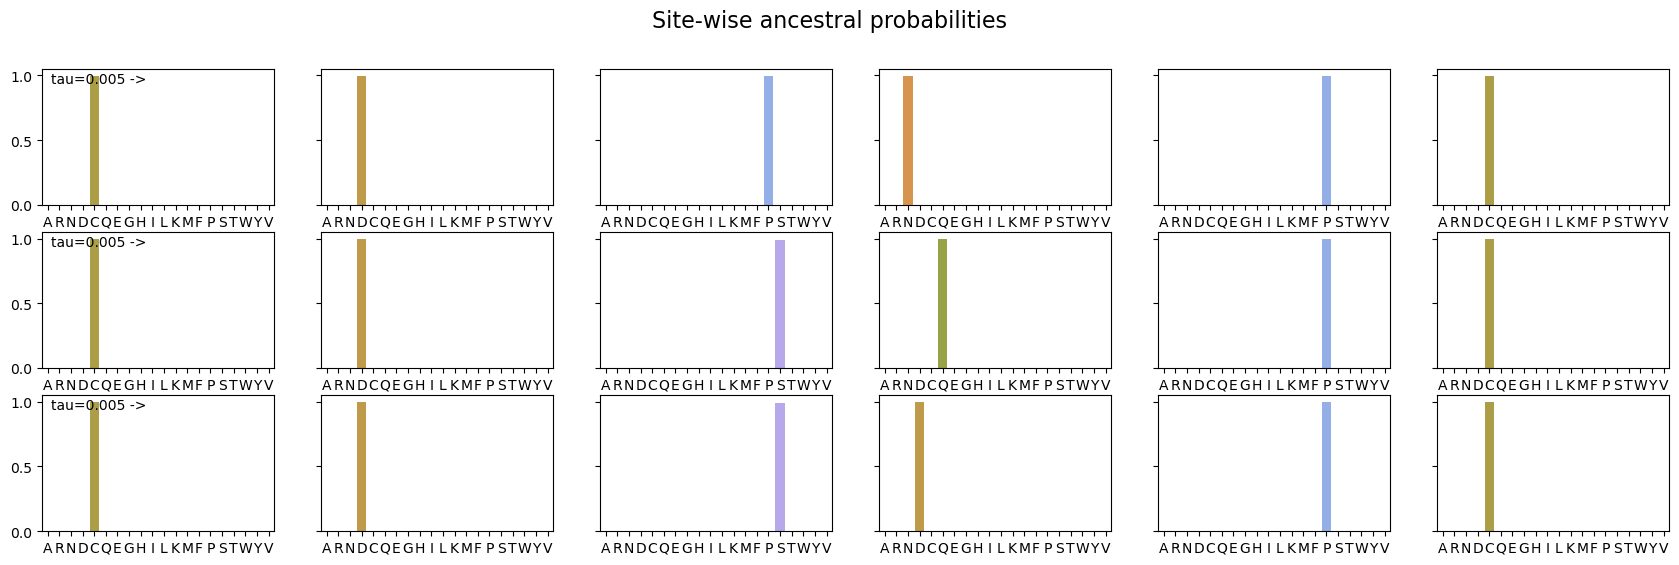

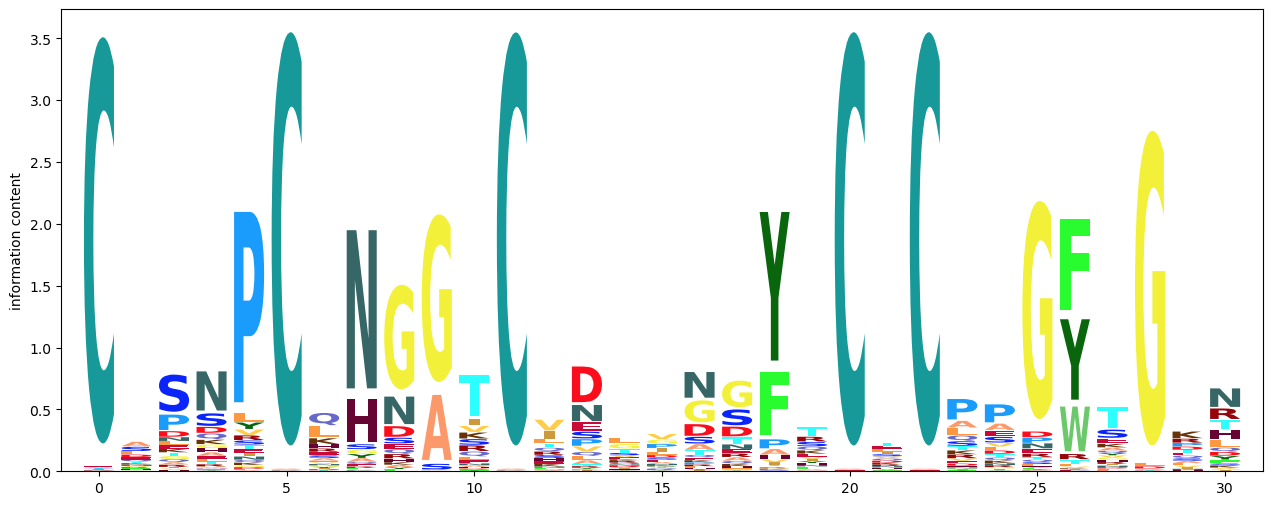

In [3]:
out_filename = "test/data/interactive.alignment.fasta"
config = Configuration.make_default(num_models)
config["batch_size"] = Configuration.get_adaptive_batch_size_with_language_model
# train a bit longer and with smaller updates than the default
config["use_language_model"] = True
config["learning_rate"] = 0.05
config["epochs"] = [10, 4, 20]
emission_init = [Initializers.EmbeddingEmissionInitializer() for _ in range(config["num_models"])]
if config["use_shared_embedding_insertions"]:
    insertion_init = [Initializers.EmbeddingEmissionInitializer() for _ in range(config["num_models"])]
else:
    insertion_init = [Initializers.make_default_insertion_init() for _ in range(config["num_models"])]
config["emitter"] = Emitter.EmbeddingEmitter(config["lm_name"], 
                                        config["reduced_embedding_dim"],
                                        config["embedding_l2_match"], 
                                        config["embedding_l2_insert"], 
                                        emission_init=emission_init, 
                                        insertion_init=insertion_init,
                                        use_shared_embedding_insertions=config["use_shared_embedding_insertions"],
                                        frozen_insertions=config["frozen_insertions"],
                                        use_finetuned_lm=config["use_finetuned_lm"])
# we have to define a special model- and batch generator if using a language model
# because the emission probabilities are computed differently and the LM requires specific inputs
model_gen = Training.embedding_model_generator
batch_gen = Training.EmbeddingBatchGenerator(config["lm_name"], config["reduced_embedding_dim"], use_finetuned_lm=config["use_finetuned_lm"])
with SequenceDataset(train_filename, fmt="fasta") as data:
    alignment_model = Align.run_learnMSA(data,
                                                out_filename,
                                                config, 
                                                model_generator=model_gen,
                                                batch_generator=batch_gen,
                                                sequence_weights=Align.compute_sequence_weights(train_filename, "tmp"),
                                                verbose=True,
                                                align_insertions=True)
    Visualize.print_and_plot(alignment_model, alignment_model.best_model)

In [4]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

HERE: 1ixa
HERE: 1apo
HERE: 1urk
HERE: 1fsb
HERE: 1esl
HERE: 1hre
HERE: 1epi
HERE: 4tgf
HERE: 1hcgb
HERE: 1dan1
HERE: 1dan2
HERE: 1rfnb


In [5]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp

*****************************************************
seq1       seq2          Sim   [ALL]           Tot  
egf           12         31.1    77.5 [100.0]   [ 5182]
